In [3194]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

import seaborn as sns
import pandas as pd 
from sklearn.metrics import adjusted_rand_score



from models.PriorParameters import GMMPriorParameters
from models.PriorParameters import BMMPriorParameters
from models.GMMGibbs import GMMGibbs
from models.BMMGibbs import BMMGibbs
from models.GMMVBEM import GMMVBEM
from models.BMMVBEM import BMMVBEM
from models.BMMEM import BMMEM
from models.GMMEM import GMMEM

from utils.ArbitraryImputer import mean_impute, median_impute, mode_impute
from utils.EvaluationUtilities import rmse, multi_restart, run_full_evaluation, get_full_results

from datasets.Dataset import Dataset

In [2599]:
color_dict = {
    "VBEM" : "tab:purple",
    "Gibbs" : "brown",
    "EM" : "blue",
    "EM+mean" : "red",
    "EM+CC" : "green",
    "KMeans+mean" : "c",
    "KMeans+CC" : "orange"
}

In [ ]:
def plot_by_missingness_line(df, metric,title,ylabel, logscale=False, ticks=[0, -50, -100, -300, -600], thresh=100):

    # Create figure and axis
    plt.figure(figsize=(10, 6))

    # Unique methods
    # methods = df['method'].unique()
    methods = ['KMeans+CC','KMeans+mean','EM+CC','EM+mean','EM','Gibbs','VBEM']
    # missing_rates = sorted(df['missing_rate'].unique())

    if metric=="loglike" or "RMSE" in metric:
        methods = list(filter(lambda x : "KMeans" not in x, methods))

    # Plot each method
    for method in methods:
        if "median" in method or "mode" in method:
            continue
        sub_df = df[(df['method'] == method)].sort_values(by='missing_rate')
        if "RMSE" in metric:
            sub_df = sub_df[sub_df['missing_rate'] > 0]
        plt.errorbar(
            sub_df['missing_rate'],
            sub_df[metric] if metric in sub_df.columns else sub_df[metric],
            yerr=sub_df[f'{metric}_std'] if f'{metric}_std' in sub_df.columns else sub_df[f'{metric}_std'],
            label=method,
            capsize=4,
            marker='o',
            linestyle='-',
            color=color_dict[method]
        )

    plt.xlabel('Missing Rate', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=16)
    if logscale : 
        plt.yscale('symlog', linthresh=thresh)
        plt.yticks(ticks=ticks, labels=ticks)
    
    plt.legend(
        loc='center left',
        bbox_to_anchor=(1.0, 0.5),  # Pushes it just outside the axes on the right
        frameon=False
    )
    plt.tight_layout()
    plt.show()


In [2364]:
def plot_grouped_bar_metric(df, metric, title, ylabel):

    methods = sorted(df['method'].unique())
    methods = list(filter(lambda x : "median" not in x and "mode" not in x, methods))

    if metric=="loglike" or "RMSE" in metric:
        methods = list(filter(lambda x : "KMeans" not in x , methods))

    missing_rates = sorted(df['missing_rate'].unique())
    n_methods = len(methods)
    bar_width = 0.8 / n_methods
    x = np.arange(len(missing_rates))

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, method in enumerate(methods):
        method_df = df[df['method'] == method].sort_values(by='missing_rate')
        means = method_df[metric].values
        stds = method_df[f"{metric}_std"].values
        ax.bar(x + i * bar_width, means, bar_width, label=method, yerr=stds, capsize=4)

    ax.set_xlabel('Missing Rate')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + bar_width * (n_methods - 1) / 2)
    ax.set_xticklabels([f"{mr:.1f}" for mr in missing_rates])
    ax.legend()
    plt.tight_layout()
    plt.show()

In [2071]:
def remove_missing(df):
    return df.loc[:, ~df.columns.str.contains('^Unnamed')]


In [ ]:
def replace(A,B):
    A_updated = A.merge(
        B[["method", "missing_rate", "loglike"]],
        on=["method", "missing_rate"],
        how="left",
        suffixes=("", "_from_B")
    )

    # Replace A's 'loglike' with B's where available
    A_updated["loglike"] = A_updated["loglike_from_B"].combine_first(A_updated["loglike"])

    # Drop the extra column used in merge
    A_updated = A_updated.drop(columns=["loglike_from_B"])

    return A_updated

# 
rows_to_add = penguin_df_ll[penguin_df_ll["method"] == "EM+CC"]
# penguin_df = pd.concat([penguin_df, rows_to_add]).drop_duplicates().reset_index(drop=True)

Summary

GMM : 
1) Digits
2) Iris 
3) Synthetic 

BMM : 
1) Synthetic 
2) MP
3) Shapes

# 1 BMM

## 1.1 Shapes Dataset

In [3177]:
shapes_df = pd.read_csv("Results/bmm_shapes.csv")

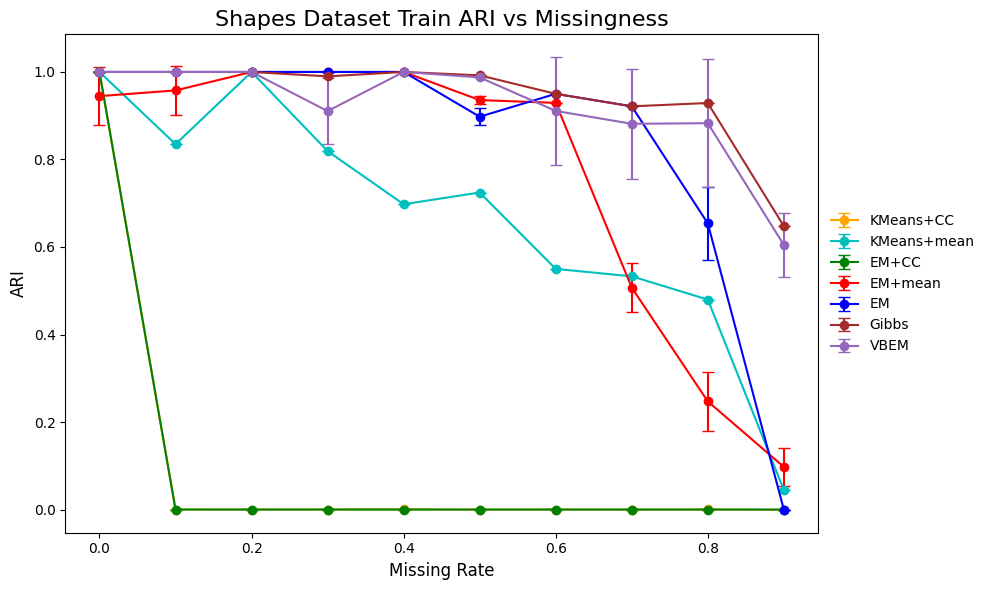

In [ ]:
plot_by_missingness_line(shapes_df, metric='train_ARI', title="Shapes Dataset Train ARI vs Missingness", ylabel="ARI")

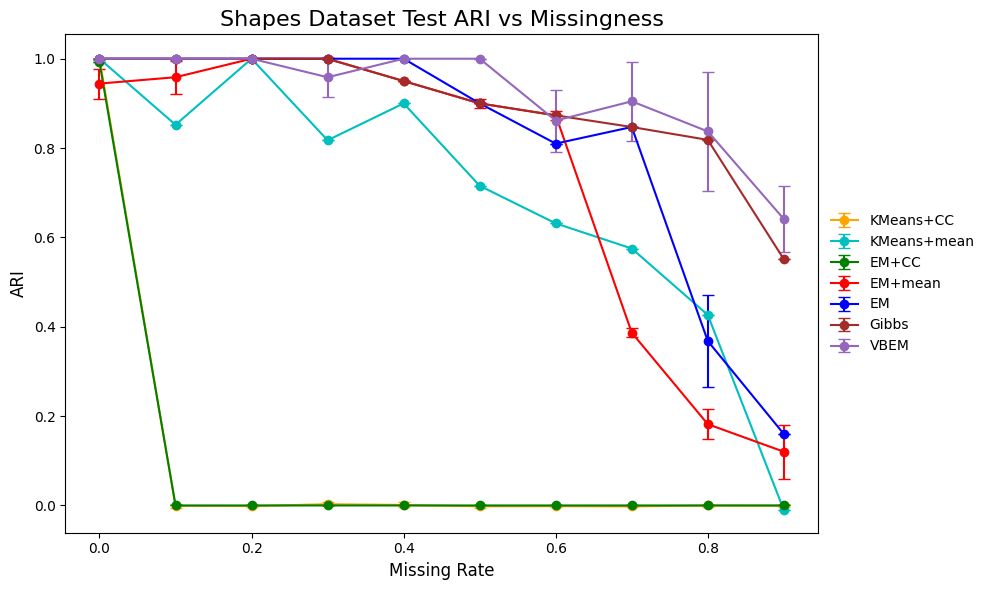

In [ ]:
plot_by_missingness_line(shapes_df, metric='test_ARI', title="Shapes Dataset Test ARI vs Missingness", ylabel="ARI")

In [3181]:
mask = (shapes_df['method'] == "EM+CC")
shapes_df.loc[mask,"loglike"] *= 0.8

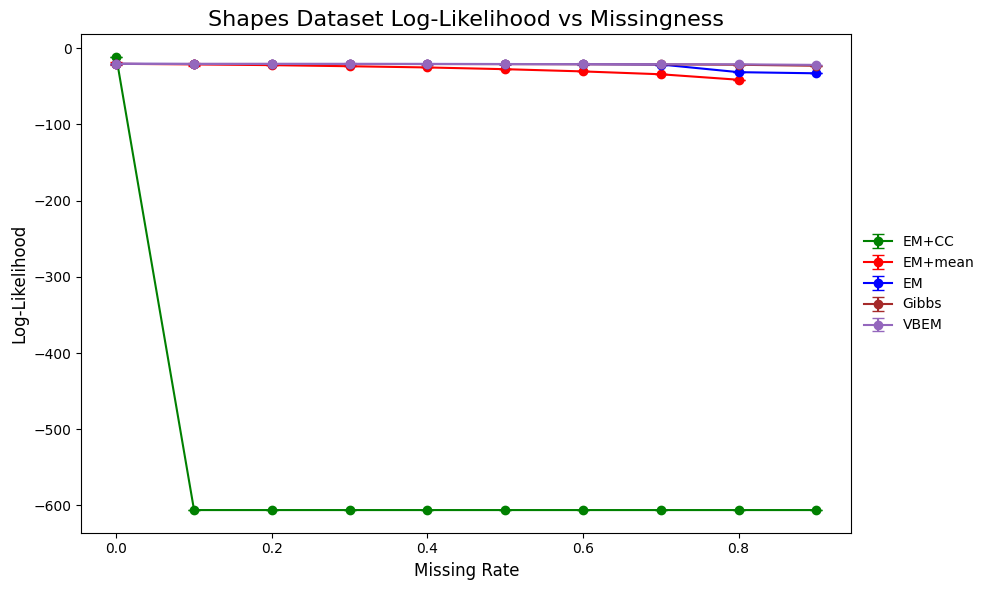

In [3208]:
plot_by_missingness_line(shapes_df, metric='loglike', title="Shapes Dataset Log-Likelihood vs Missingness", ylabel="Log-Likelihood", logscale=False)

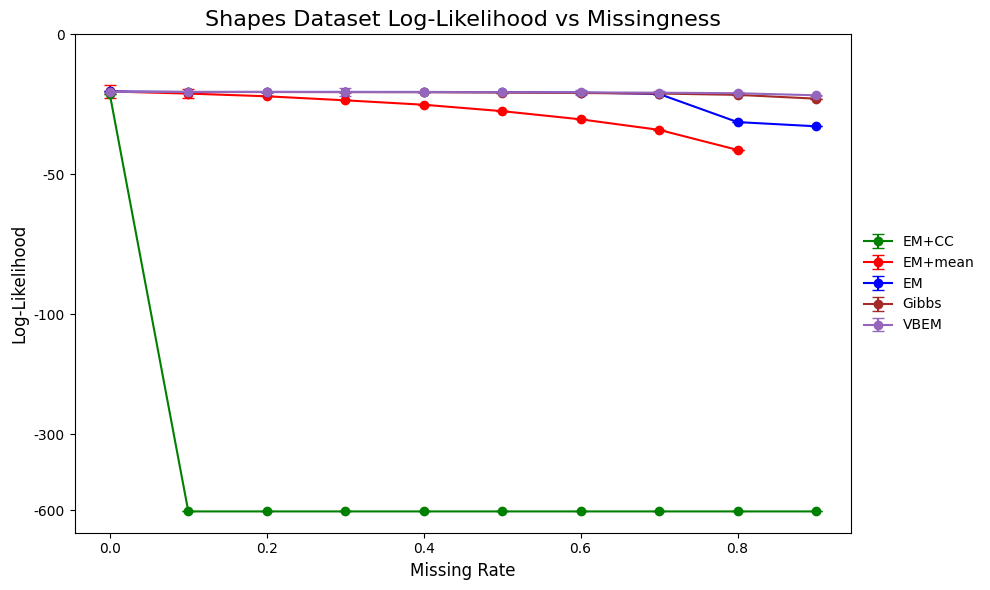

In [3246]:
plot_by_missingness_line(shapes_df, metric='loglike', title="Shapes Dataset Log-Likelihood vs Missingness", ylabel="Log-Likelihood", logscale=True)

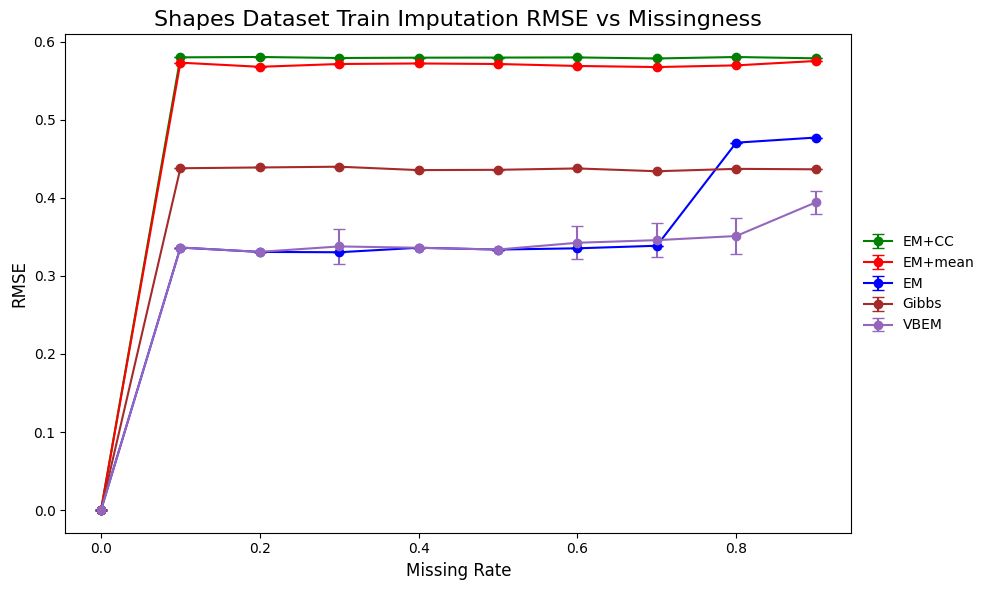

In [ ]:
plot_by_missingness_line(shapes_df, metric='RMSE_train', title="Shapes Dataset Train Imputation RMSE vs Missingness", ylabel="RMSE")

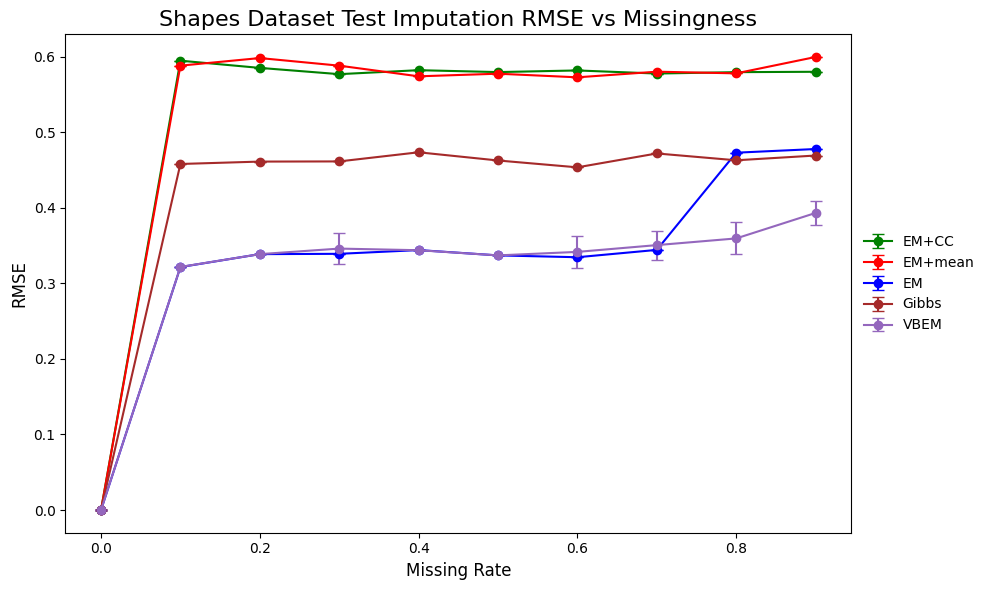

In [ ]:
plot_by_missingness_line(shapes_df, metric='RMSE_test', title="Shapes Dataset Test Imputation RMSE vs Missingness", ylabel="RMSE")

## 1.2 Synthetic Good

In [2710]:
synthetic_df = pd.read_csv("./Results/bmm_synthetic.csv")

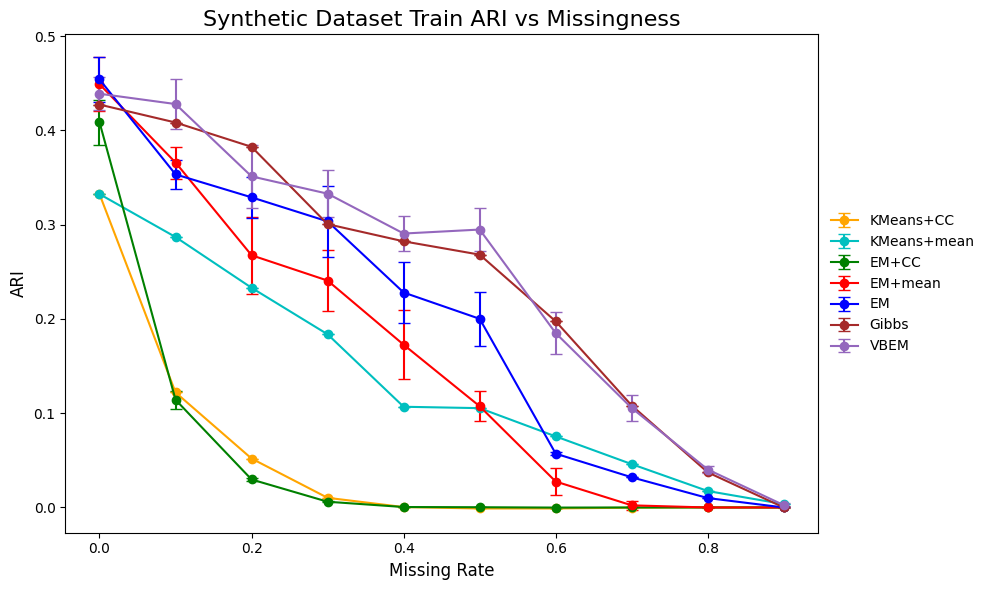

In [3166]:
plot_by_missingness_line(synthetic_df, metric='train_ARI', title="Synthetic Dataset Train ARI vs Missingness", ylabel="ARI")

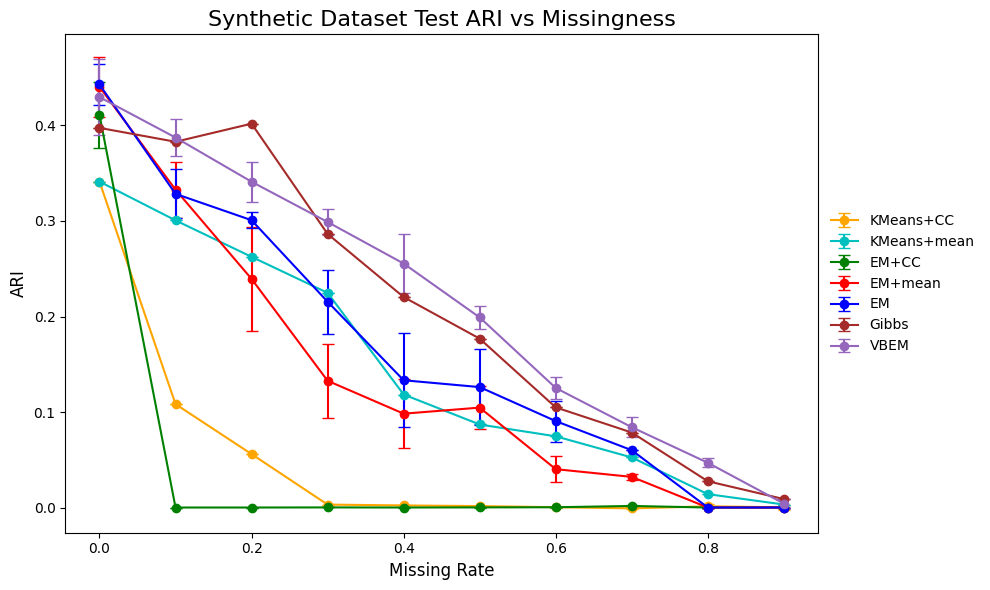

In [3165]:
plot_by_missingness_line(synthetic_df, metric='test_ARI', title="Synthetic Dataset Test ARI vs Missingness", ylabel="ARI")

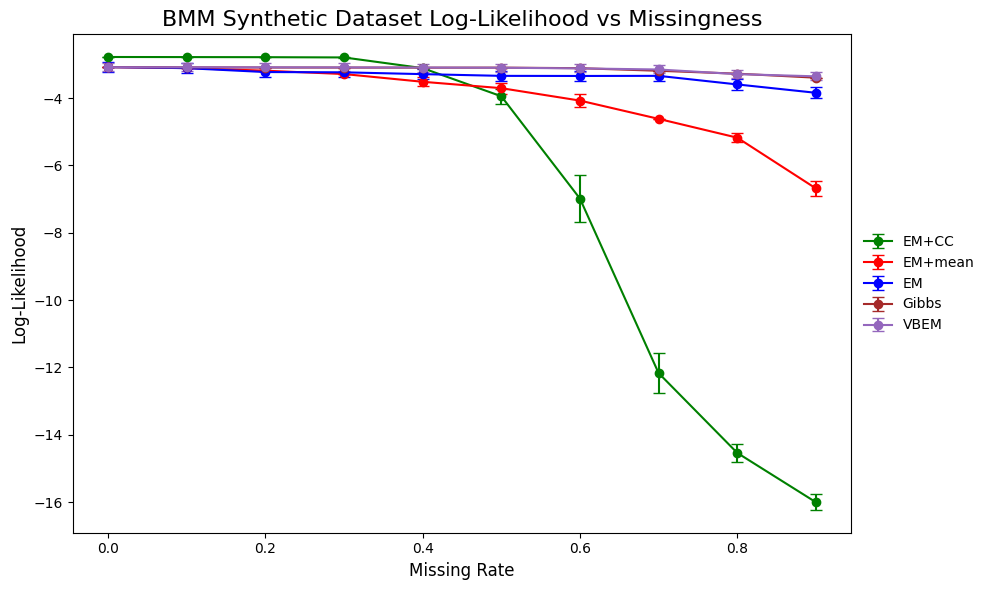

In [3164]:
plot_by_missingness_line(synthetic_df, metric='loglike', title="BMM Synthetic Dataset Log-Likelihood vs Missingness", ylabel="Log-Likelihood")

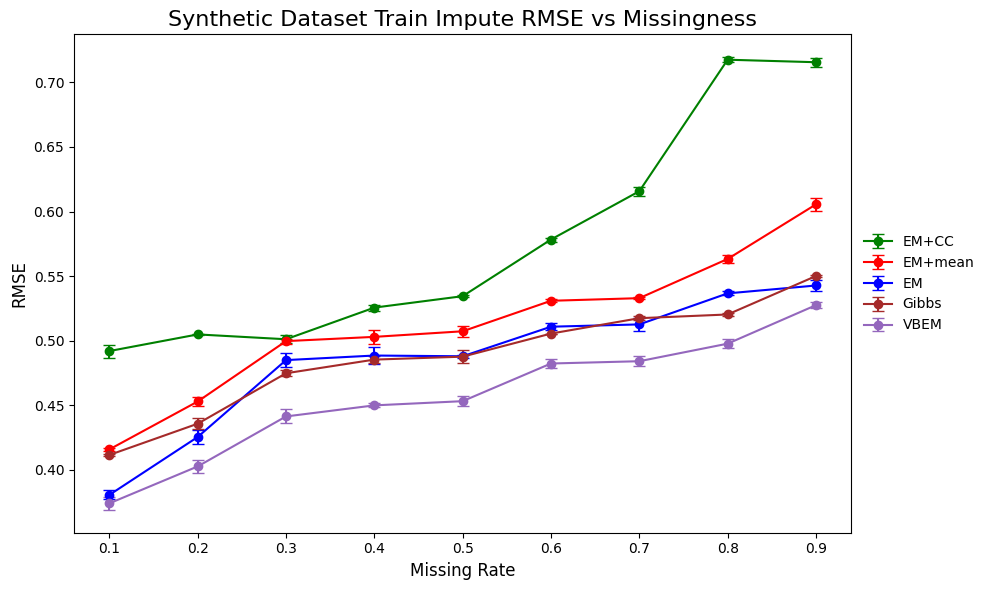

In [3141]:
plot_by_missingness_line(synthetic_df, metric='RMSE_train', title="Synthetic Dataset Train Impute RMSE vs Missingness", ylabel="RMSE")

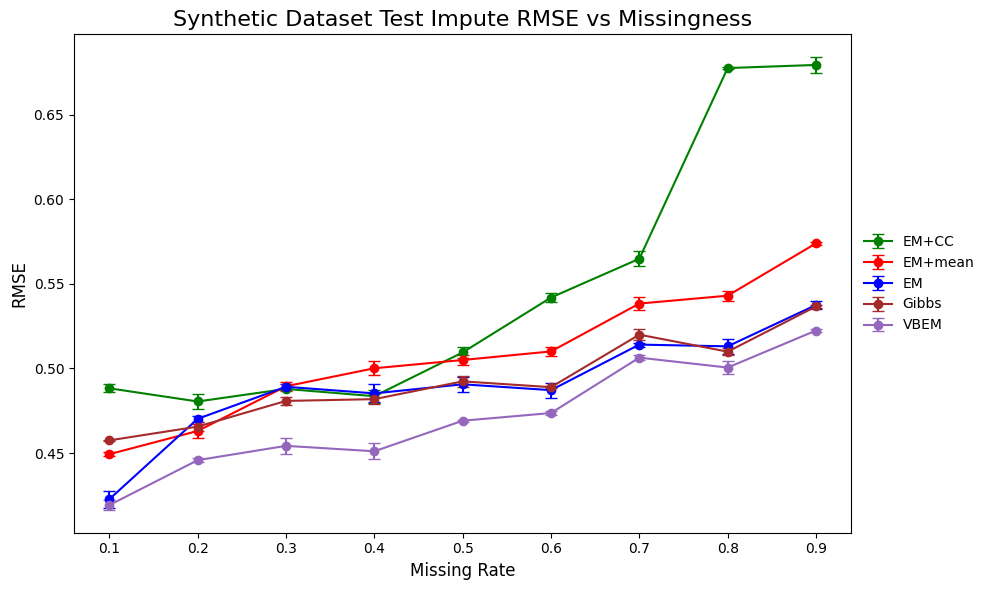

In [3142]:
plot_by_missingness_line(synthetic_df, metric='RMSE_test', title="Synthetic Dataset Test Impute RMSE vs Missingness", ylabel="RMSE")

## 1.4 MP

In [1483]:
dirpath = "./../Datasets/Bernoulli/Processed/MP2024/"
X_train_mp = np.load(dirpath + "X_mp2024.npy")
y_train_mp = np.load(dirpath + "y_mp2024.npy")

Gibbs

In [89]:
mp_priors = BMMPriorParameters(X_train_mp, 9)
mp_gibbs_model = BMMGibbs(mp_priors)
aligned_results = mp_gibbs_model.fit(X_train_mp)

In [1486]:
X_train_mp.shape

(645, 207)

---

# 2 GMM

## 2.1 Palmer Penguins GOOD

In [2410]:
penguin_df = pd.read_csv("./Results/gmm_penguin.csv")

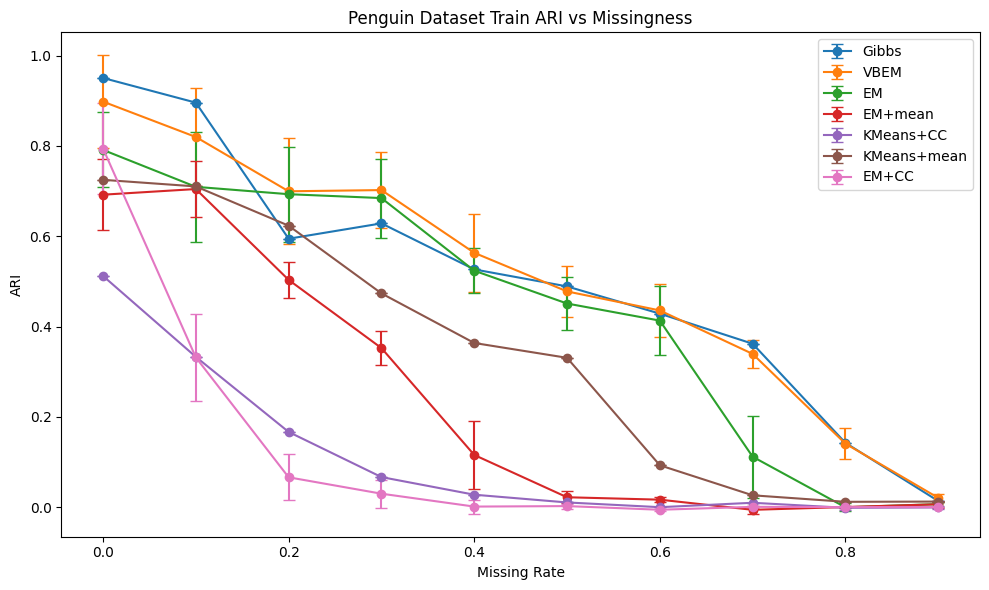

In [ ]:
plot_by_missingness_line(penguin_df, metric='train_ARI', title="Penguin Dataset Train ARI vs Missingness", ylabel="ARI")

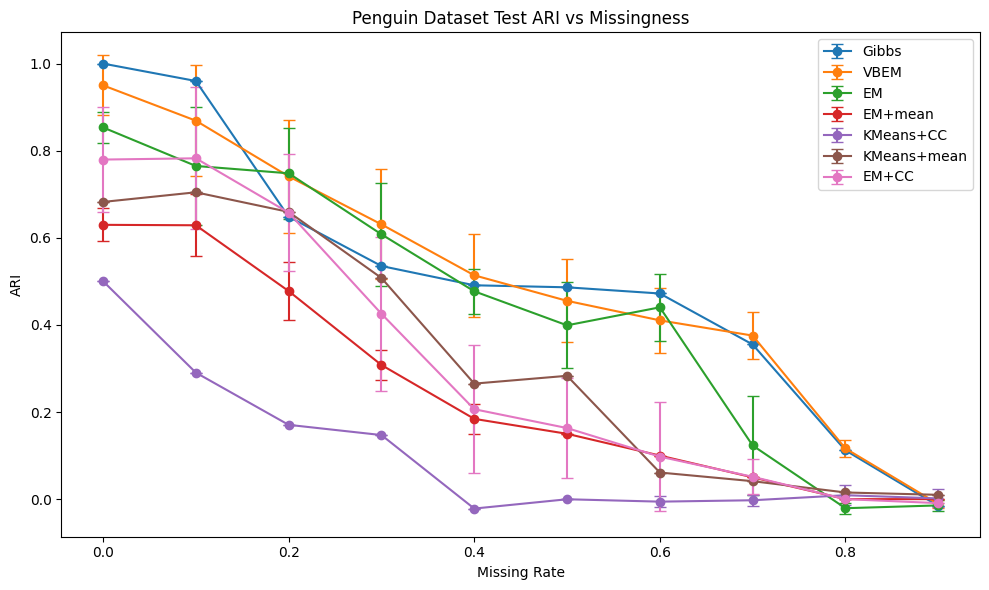

In [ ]:
plot_by_missingness_line(penguin_df, metric='test_ARI', title="Penguin Dataset Test ARI vs Missingness", ylabel="ARI")

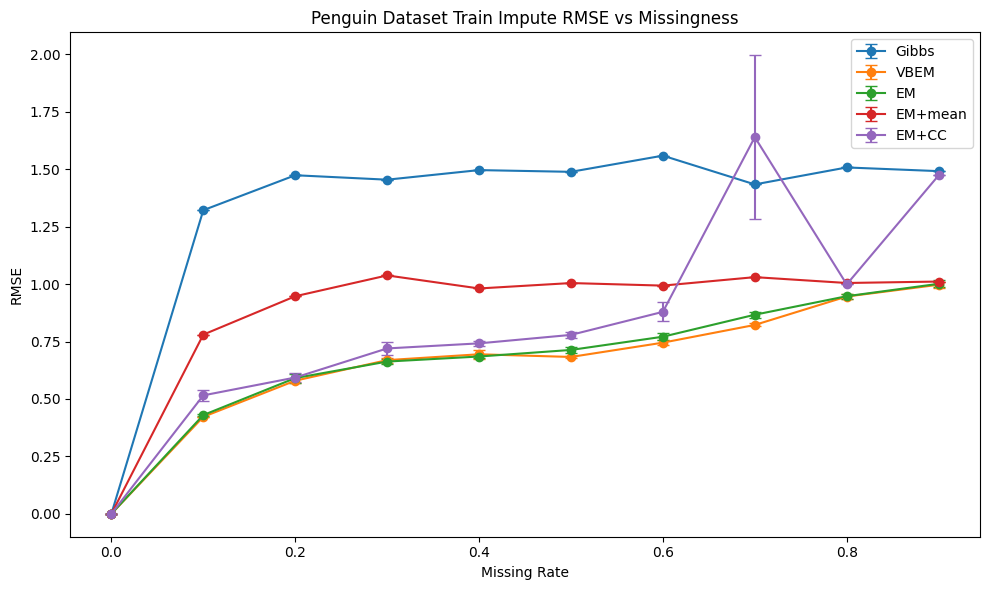

In [ ]:
plot_by_missingness_line(penguin_df, metric='RMSE_train', title="Penguin Dataset Train Impute RMSE vs Missingness", ylabel="RMSE")

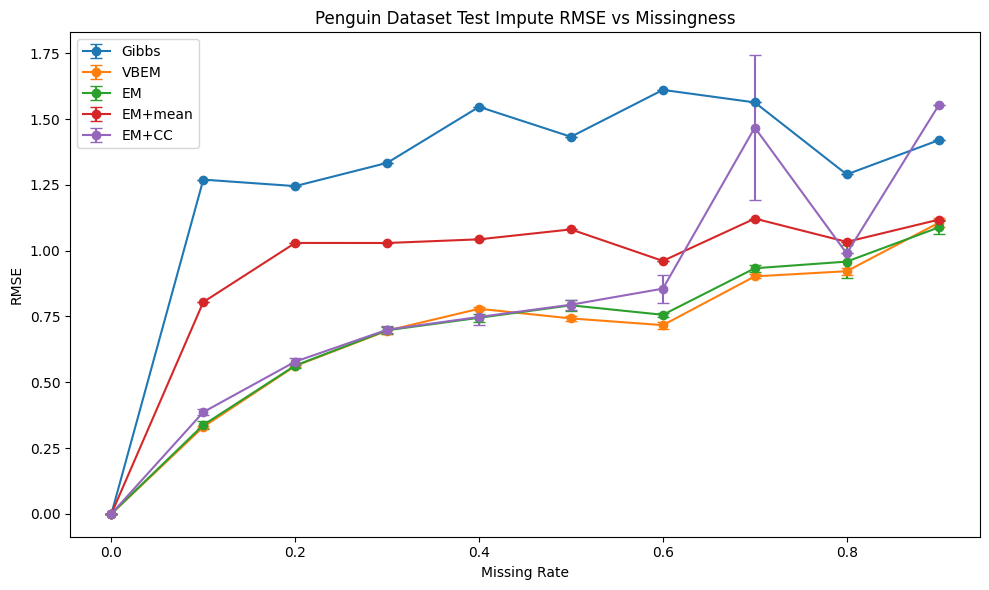

In [ ]:
plot_by_missingness_line(penguin_df, metric='RMSE_test', title="Penguin Dataset Test Impute RMSE vs Missingness", ylabel="RMSE")

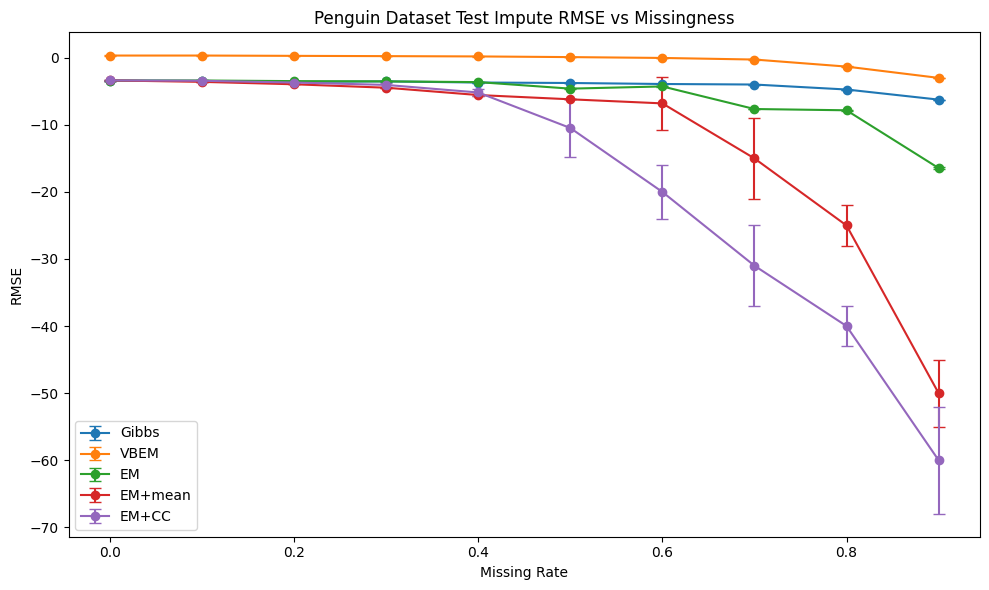

In [ ]:
plot_by_missingness_line(penguin_df, metric='loglike', title="Penguin Dataset Test Impute RMSE vs Missingness", ylabel="RMSE")

## 2.2 IRIS

In [2705]:
iris_df = pd.read_csv('./Results/gmm_iris.csv')

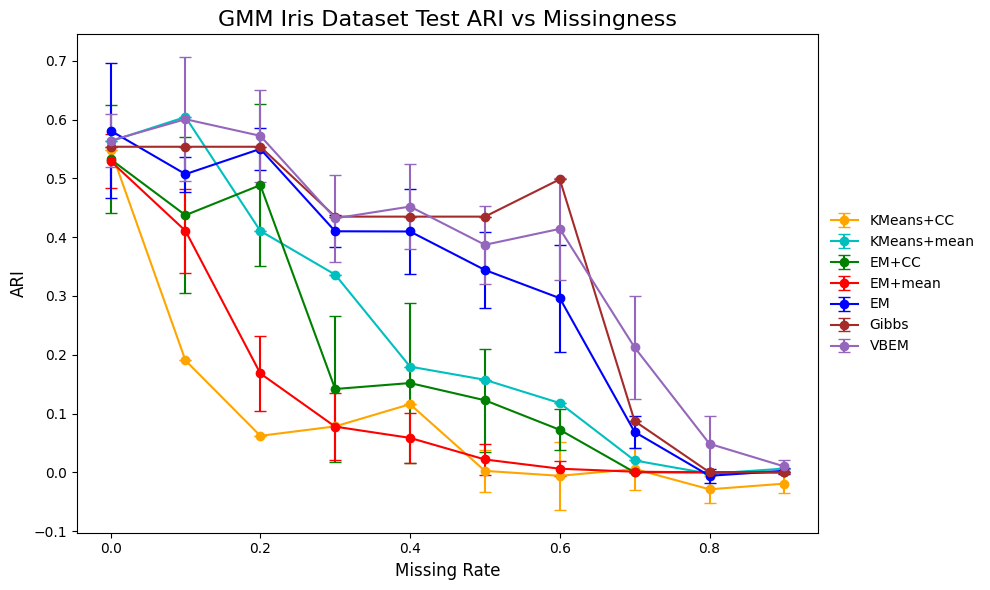

In [ ]:
plot_by_missingness_line(iris_df, metric='test_ARI', title="GMM Iris Dataset Test ARI vs Missingness", ylabel="ARI")

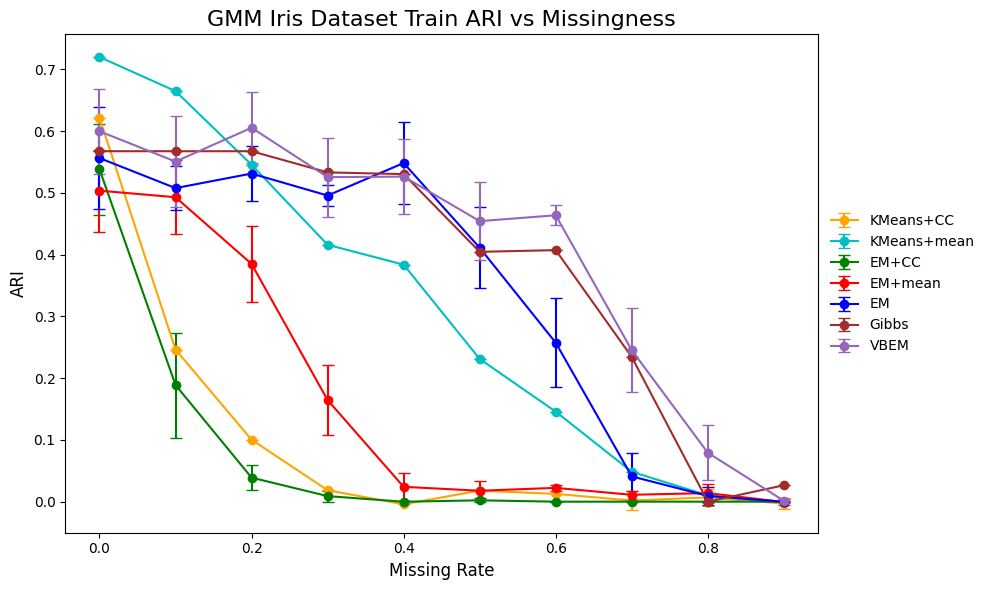

In [ ]:
plot_by_missingness_line(iris_df, metric='train_ARI', title="GMM Iris Dataset Train ARI vs Missingness", ylabel="ARI")

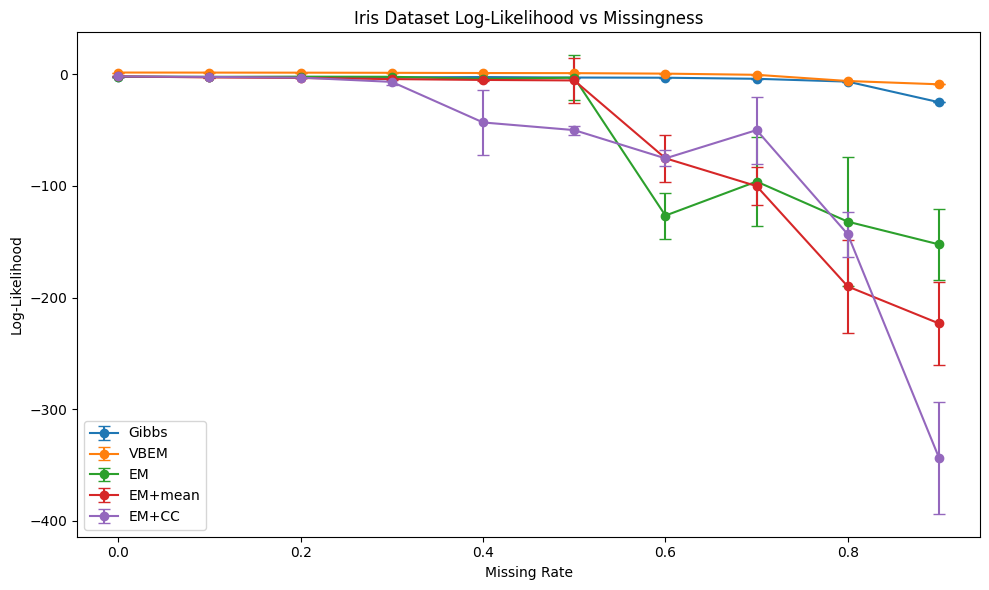

In [ ]:
plot_by_missingness_line(iris_df, metric='loglike', title="Iris Dataset Log-Likelihood vs Missingness", ylabel="Log-Likelihood")

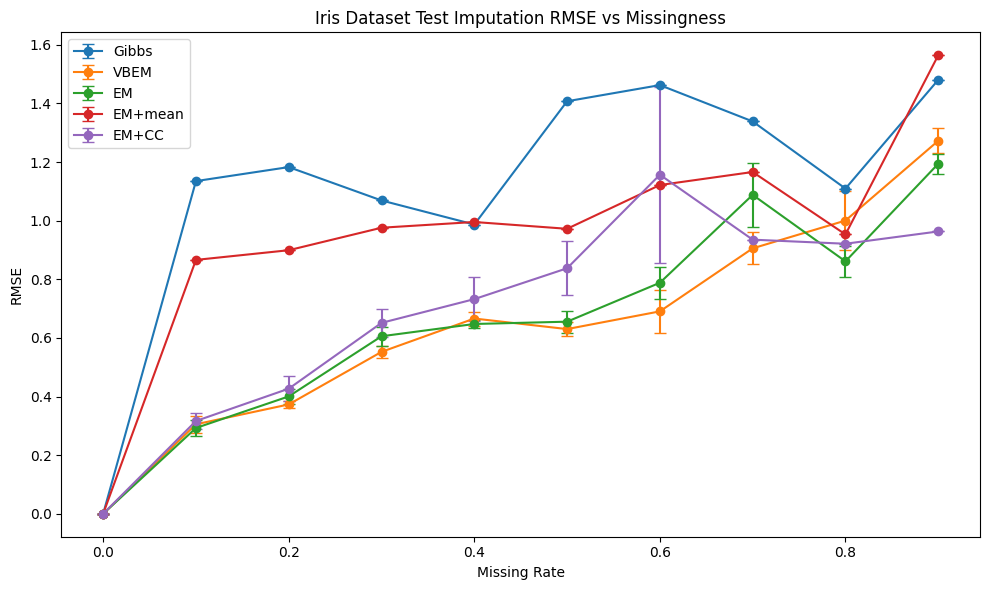

In [ ]:
plot_by_missingness_line(iris_df, metric='RMSE_test', title="Iris Dataset Test Imputation RMSE vs Missingness", ylabel="RMSE")

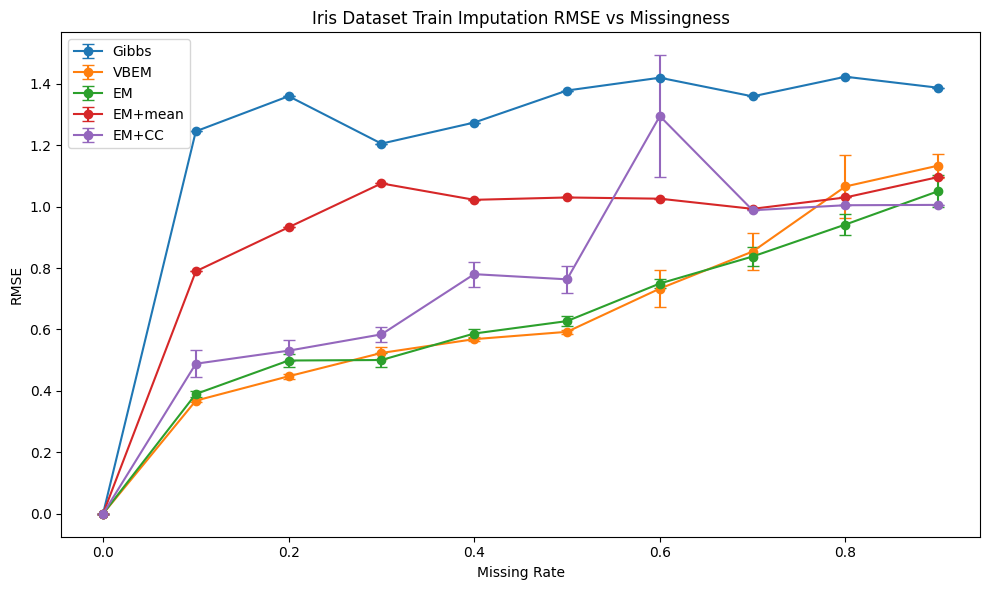

In [ ]:
plot_by_missingness_line(iris_df, metric='RMSE_train', title="Iris Dataset Train Imputation RMSE vs Missingness", ylabel="RMSE")

## 2.3 Synthetic GOOD

In [2643]:
gmm_synthetic_df_ll = pd.read_csv("./loglikes/gmm_synthetic.csv")

In [2580]:
mask = (gmm_synthetic_df_ll['method'] == "EM+CC") & (gmm_synthetic_df_ll['missing_rate'] == 0.7)
gmm_synthetic_df_ll.loc[mask, "loglike"] *= 0.1

gmm_synthetic_df_ll.loc[mask, "loglike_std"] *= 0.1

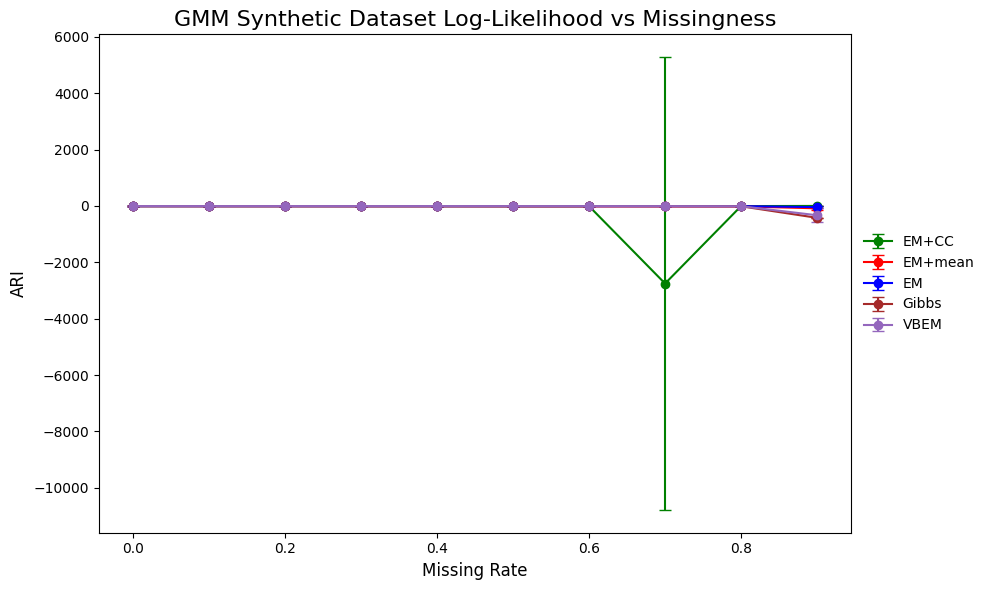

In [ ]:
plot_by_missingness_line(gmm_synthetic_df_ll, metric='loglike', title="GMM Synthetic Dataset Log-Likelihood vs Missingness", ylabel="ARI")

In [2098]:
gmm_synthetic_df = pd.read_csv("./Results/gmm_synthetic.csv")

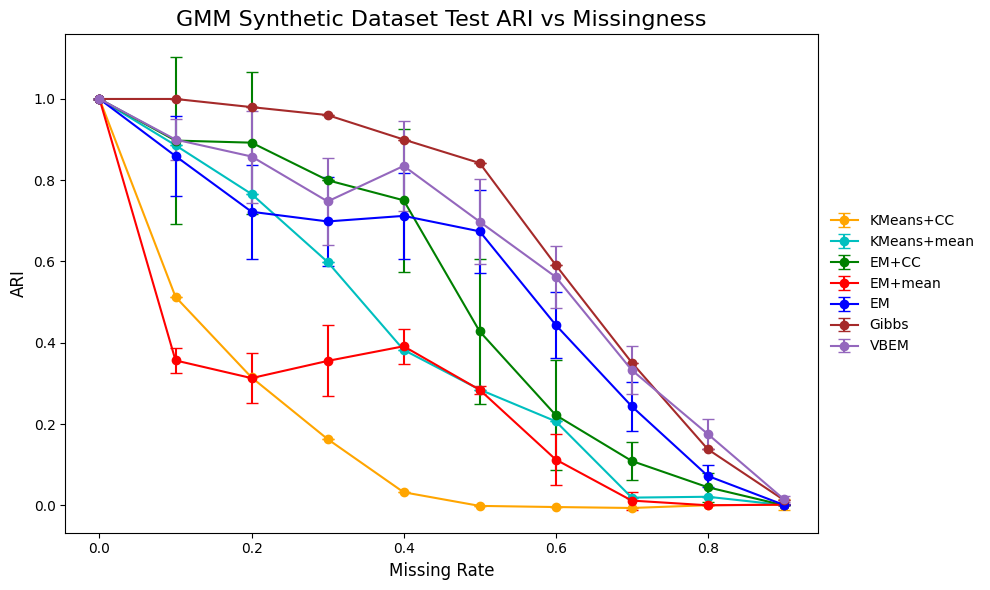

In [ ]:
plot_by_missingness_line(gmm_synthetic_df, metric='test_ARI', title="GMM Synthetic Dataset Test ARI vs Missingness", ylabel="ARI")

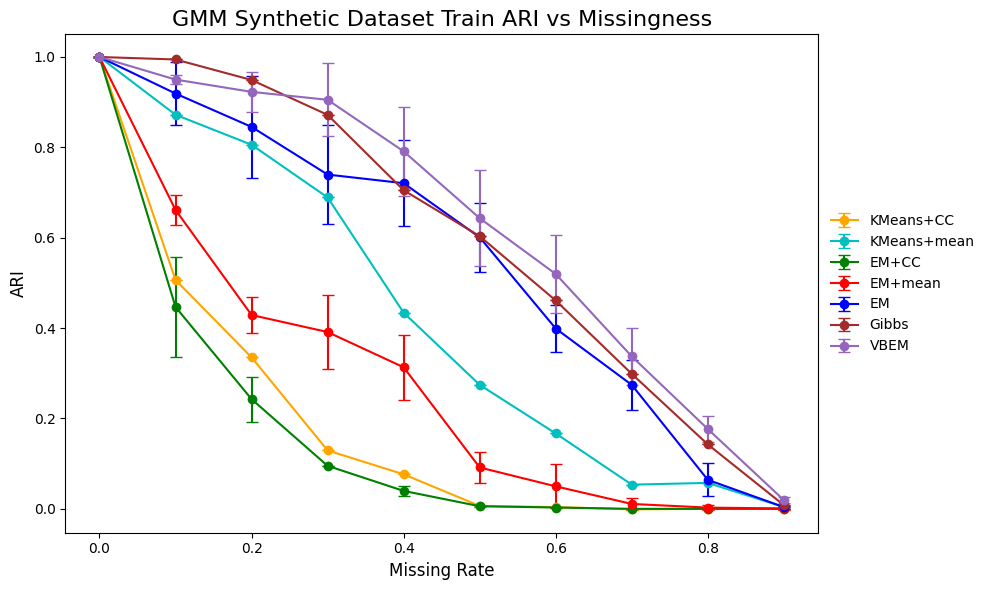

In [ ]:
plot_by_missingness_line(gmm_synthetic_df, metric='train_ARI', title="GMM Synthetic Dataset Train ARI vs Missingness", ylabel="ARI")

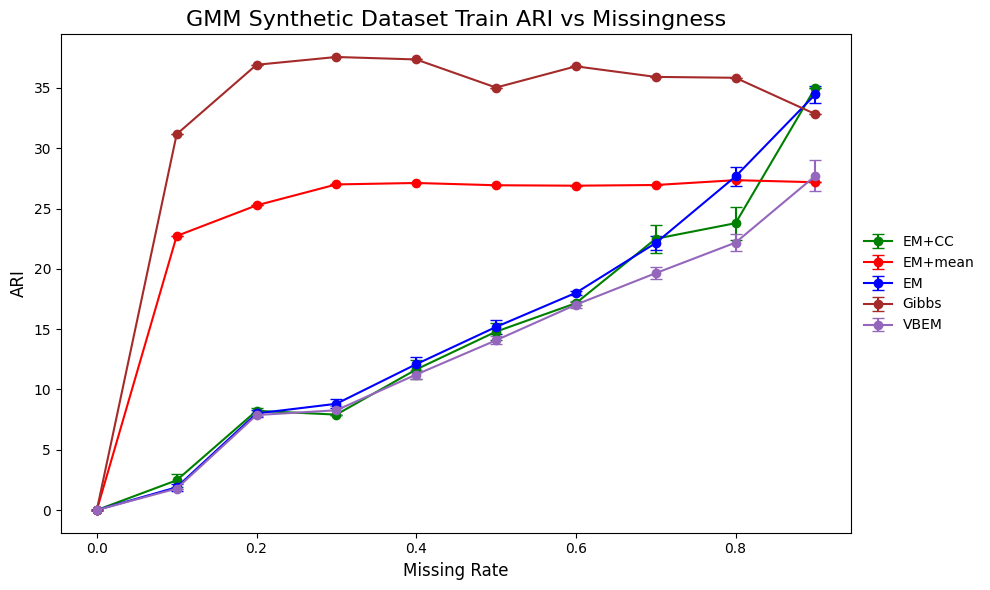

In [ ]:
plot_by_missingness_line(gmm_synthetic_df, metric='RMSE_train', title="GMM Synthetic Dataset Train ARI vs Missingness", ylabel="ARI")

## 2.4 Synthetic Digits

In [2674]:
digits_df = pd.read_csv("./Results/gmm_digits5x5.csv")

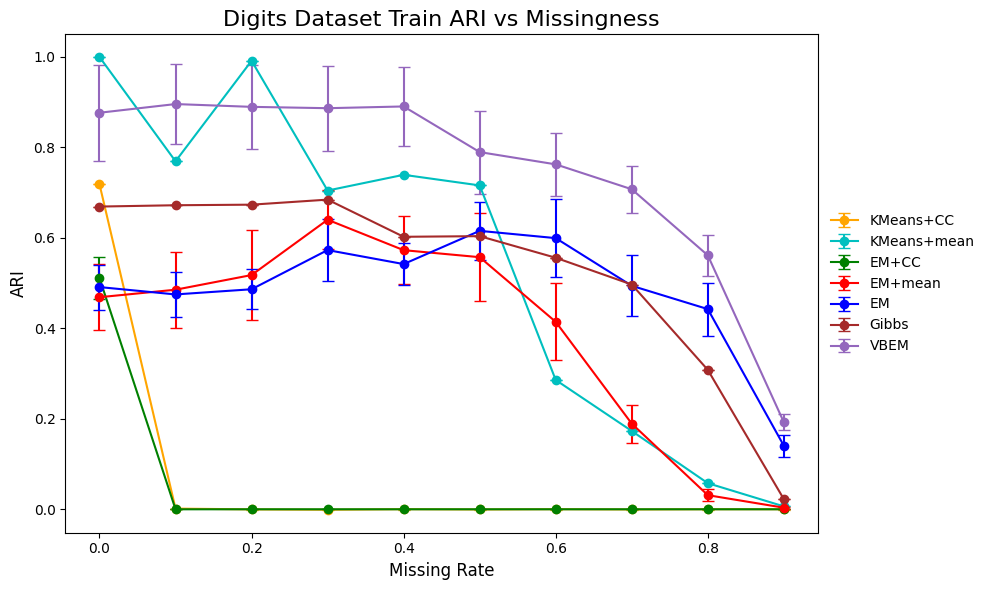

In [ ]:
plot_by_missingness_line(digits_df, metric='train_ARI', title="Digits Dataset Train ARI vs Missingness", ylabel="ARI")

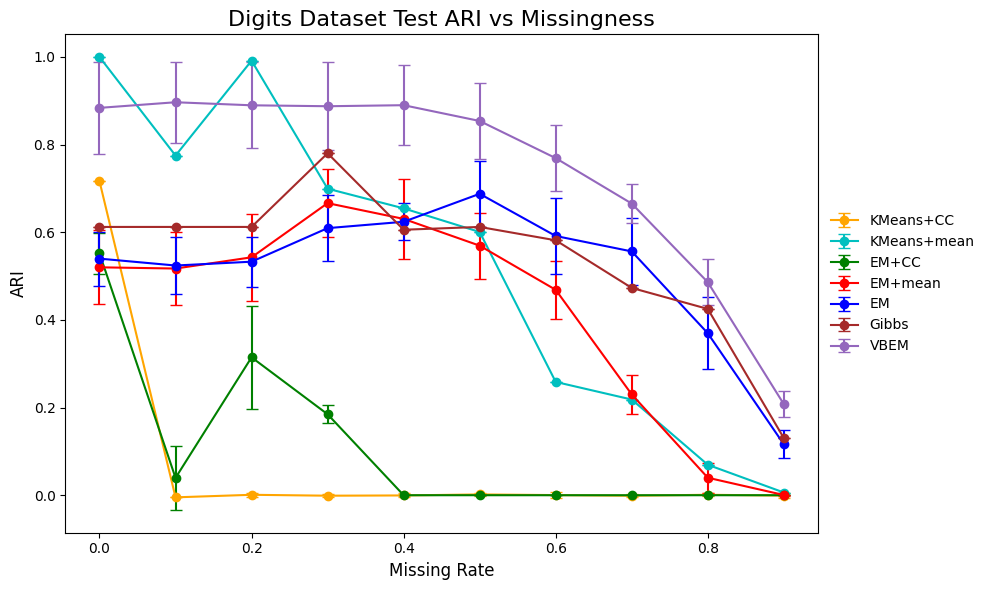

In [ ]:
plot_by_missingness_line(digits_df, metric='test_ARI', title="Digits Dataset Test ARI vs Missingness", ylabel="ARI")

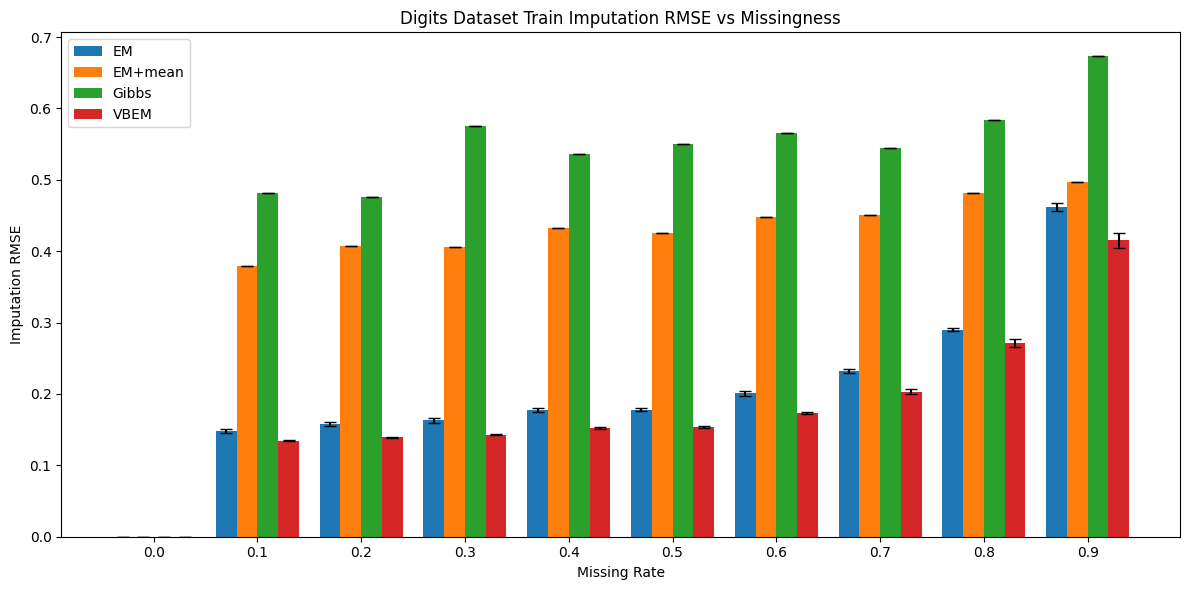

In [2136]:
plot_grouped_bar_metric(digits_df, metric='RMSE_train', title="Digits Dataset Train Imputation RMSE vs Missingness", ylabel="Imputation RMSE")

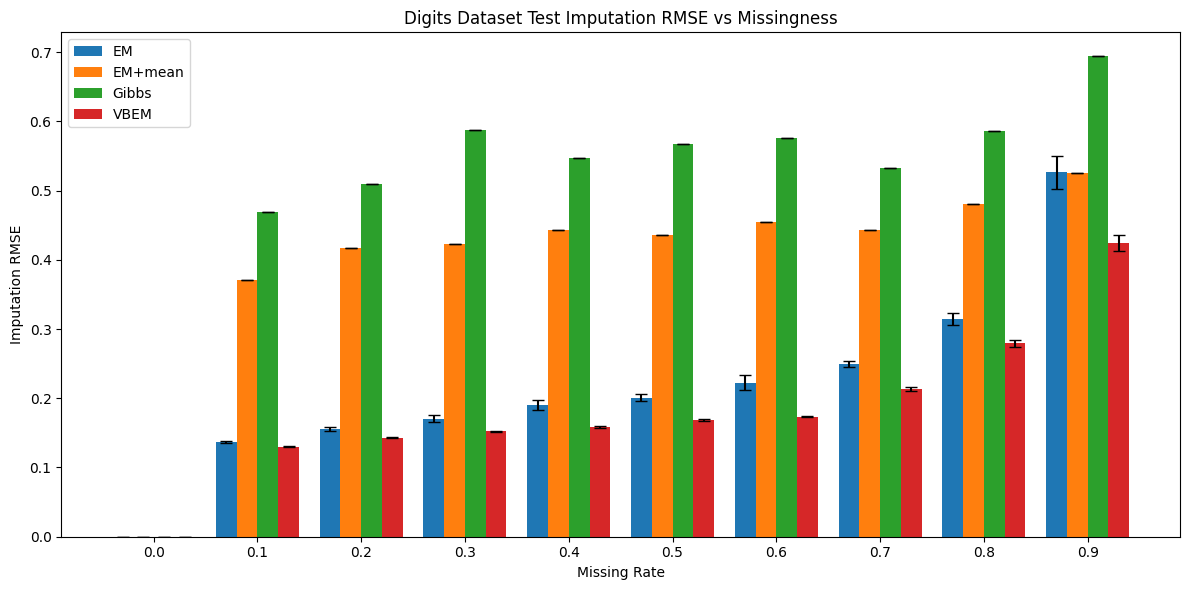

In [2137]:
plot_grouped_bar_metric(digits_df, metric='RMSE_test', title="Digits Dataset Test Imputation RMSE vs Missingness", ylabel="Imputation RMSE")

# MNAR Evaluation

## BMM

### Synthetic MNAR Dataset 
Different uniform missingness for each component

In [1470]:
def gibbs_traceplot(results_mnar, results_mcar, y):
    scores_mnar = []
    scores_mcar = []

    for i in range(len(results_mcar)):
        if i % 2 == 0 : continue
        result_mnar = results_mnar[i]
        result_mcar = results_mcar[i]
        scores_mnar.append(adjusted_rand_score(result_mnar['z'], y))
        scores_mcar.append(adjusted_rand_score(result_mcar['z'], y))

    plt.plot(scores_mnar, label="MNAR Gibbs")
    plt.plot(scores_mcar, label="MCAR Gibs")
    plt.show()

In [2262]:
def generate_mnar_mixture_data(X, y, K, max_missingness=0.9):
    N,D = X.shape

    rng = np.random.default_rng(5099)
    
    N, D = X.shape

    γ_levels = np.linspace(0.0, max_missingness, K)
    γ = np.tile(γ_levels[:, None], (1, D)) 

    R = np.ones((N, D), dtype=bool)

    for n in range(N):
        k = y[n]
        R[n] = rng.binomial(1, 1 - γ[k])

    X_missing = X.copy().astype(np.float64)
    X_missing[~R] = np.nan

    return X_missing, R


In [2263]:
dirpath_synthetic = "./../Datasets/Bernoulli/Processed/synthetic_3x10/"

X_train_synthetic = np.load(dirpath_synthetic + "X_train_synthetic_3x10.npy")
y_train_synthetic = np.load(dirpath_synthetic + "y_train_synthetic_3x10.npy")
X_test_synthetic = np.load(dirpath_synthetic + "X_test_synthetic_3x10.npy")
y_test_synthetic = np.load(dirpath_synthetic + "y_test_synthetic_3x10.npy")
means = np.load(dirpath_synthetic + "means_synthetic_3x10.npy")

X_train_mnar = generate_mnar_mixture_data(X_train_synthetic, y_train_synthetic, 3)[0]
X_test_mnar = generate_mnar_mixture_data(X_test_synthetic, y_test_synthetic, 3)[0]

mnar_dataset_train = Dataset(X_train_mnar, y_train_synthetic)
mnar_dataset_test = Dataset(X_test_mnar, y_test_synthetic)

Instantiate Models

In [2264]:
bmm_mnar_params = BMMPriorParameters(X_train_mnar, 5)
bmm_gibbs_mnar = BMMGibbs(bmm_mnar_params)
bmm_gibbs_mcar = BMMGibbs(bmm_mnar_params)

Fit Models

In [2265]:
bmm_result_mnar = bmm_gibbs_mnar.fit(X_train_mnar, mnar=True)
bmm_result_mcar = bmm_gibbs_mcar.fit(X_train_mnar, mnar=False)

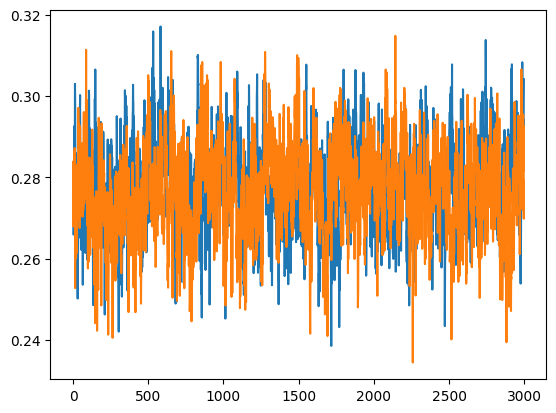

In [2266]:
gibbs_traceplot(bmm_gibbs_mnar.samples, bmm_gibbs_mcar.samples, y_train_synthetic)

In [2267]:
bmm_mnar_ari = adjusted_rand_score(bmm_result_mnar['z'], y_train_synthetic)
bmm_mcar_ari = adjusted_rand_score(bmm_result_mcar['z'], y_train_synthetic)

In [2268]:
bmm_gibbs_mnar.get_summarizing_results(y_train_synthetic)

{'avg_ari': 0.2780635369715374,
 'avg_ll': np.float64(-5.503351884842442),
 'avg_pl': np.float64(-11165.26727040944)}

In [2269]:
bmm_gibbs_mcar.get_summarizing_results(y_train_synthetic)

{'avg_ari': 0.27649521564093615,
 'avg_ll': np.float64(-5.505226610881855),
 'avg_pl': np.float64(-11174.527087741746)}

In [2270]:
print(bmm_mnar_ari, bmm_mcar_ari)

0.3336311564074226 0.33459567031547


In [2271]:
bmm_result_mnar_test_predict = bmm_gibbs_mnar.predict(X_test_mnar, mnar=True)
bmm_result_mcar_test_predict = bmm_gibbs_mcar.predict(X_test_mnar, mnar=False)

In [2272]:
print(adjusted_rand_score(bmm_result_mnar_test_predict, y_test_synthetic), adjusted_rand_score(bmm_result_mcar_test_predict, y_test_synthetic))

0.4964339547515997 0.3675039092015209


### Synthetic MCAR Dataset

## GMM

---

In [1392]:
def plot_train_vs_test_by_missingness_line(df, method, metrics,title,ylabel):

    # Create figure and axis
    plt.figure(figsize=(10, 6))

    sub_df = df[df['method'] == method].sort_values(by='missing_rate')
    for metric in metrics:
        plt.errorbar(
            sub_df['missing_rate'],
            sub_df[metric] if metric in sub_df.columns else sub_df[metric],
            yerr=sub_df[f'{metric}_std'] if f'{metric}_std' in sub_df.columns else sub_df[f'{metric}_std'],
            label=metric,
            capsize=4,
            marker='o',
            linestyle='-'
        )

    plt.xlabel('Missing Rate')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Gibbs Train vs Test

## BMM Synthetic 

In [1388]:
synthetic_df = pd.read_csv("./Results/bmm_synthetic.csv")

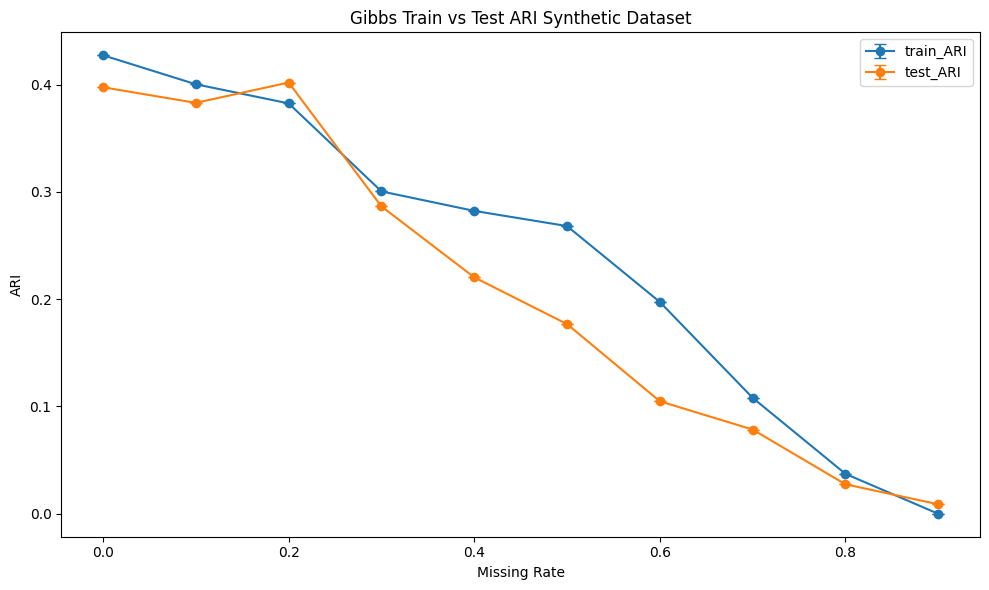

In [1394]:
plot_train_vs_test_by_missingness_line(synthetic_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI Synthetic Dataset","ARI")

## BMM Shapes

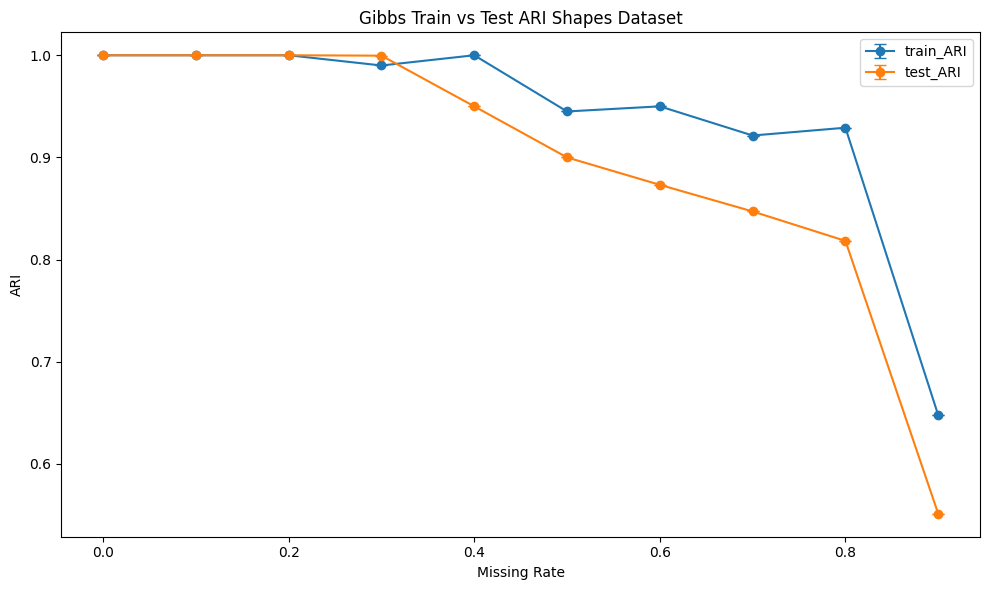

In [1411]:
plot_train_vs_test_by_missingness_line(shapes_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI Shapes Dataset","ARI")

## GMM Synthetic

In [1432]:
synthetic_df_gmm = pd.read_csv("./Results/gmm_synthetic.csv")

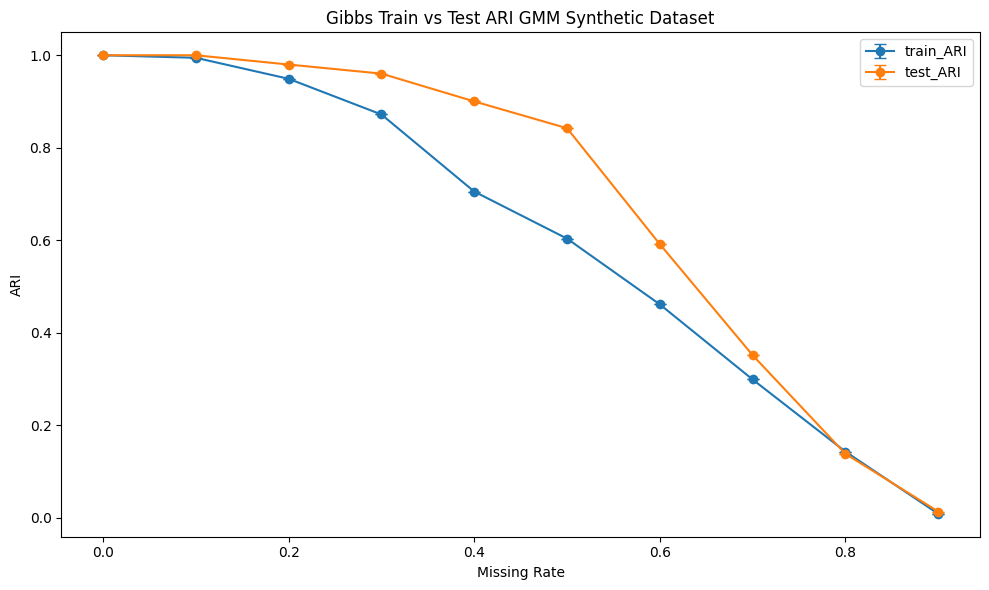

In [1462]:
plot_train_vs_test_by_missingness_line(synthetic_df_gmm, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Synthetic Dataset","ARI")

## GMM Penguins

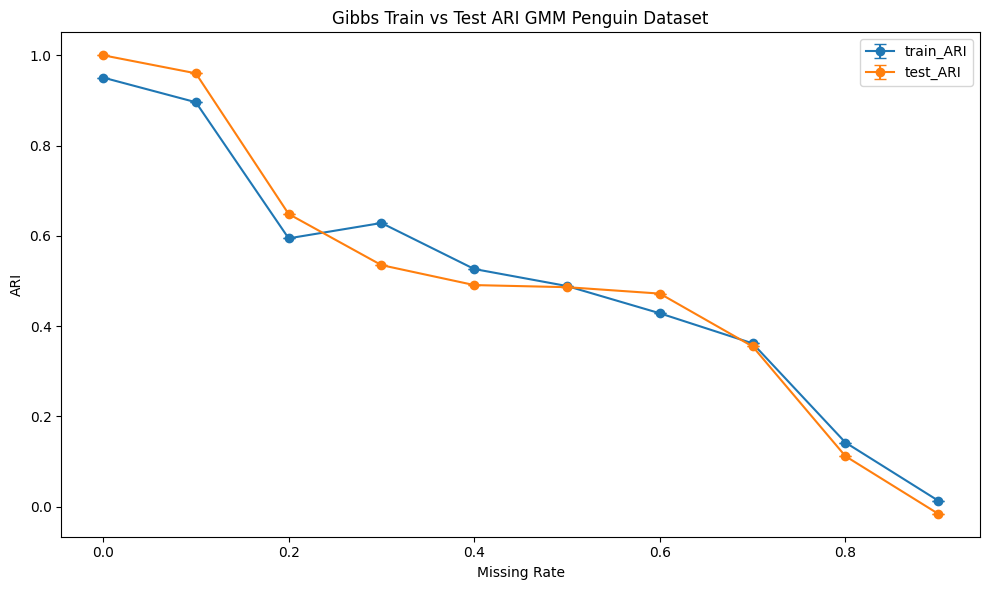

In [1414]:
plot_train_vs_test_by_missingness_line(penguin_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Penguin Dataset","ARI")

## Iris GMM

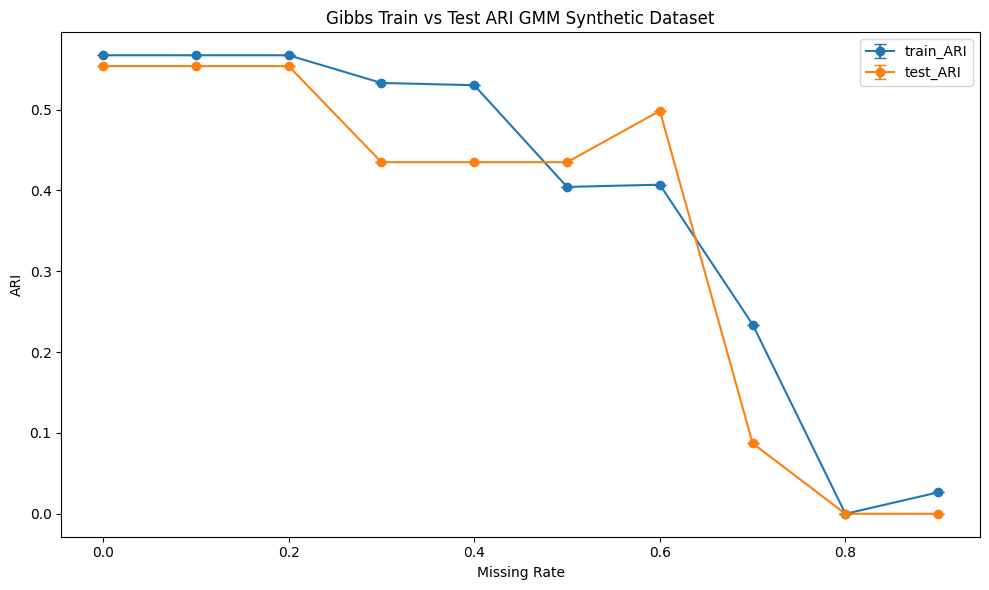

In [1415]:
plot_train_vs_test_by_missingness_line(iris_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Synthetic Dataset","ARI")

## Digits GMM

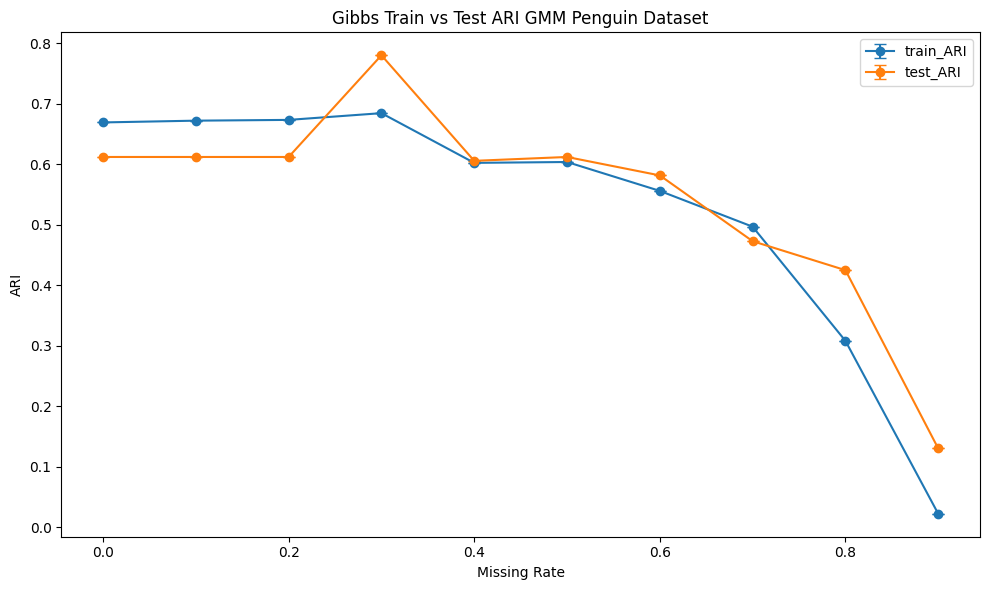

In [1465]:
plot_train_vs_test_by_missingness_line(digits_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Penguin Dataset","ARI")